In [1]:
%pip install -q matplotlib ipywidgets ipympl

Note: you may need to restart the kernel to use updated packages.


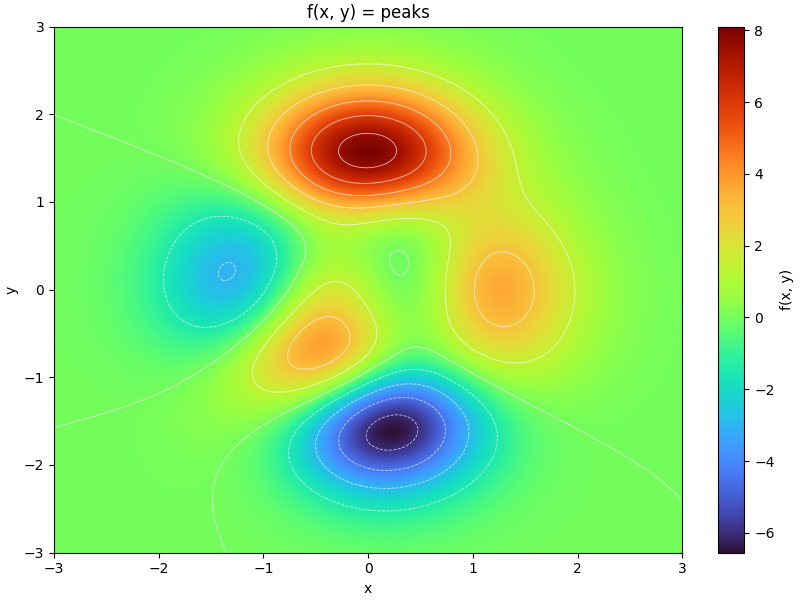

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import HTML, display


display(
    HTML(
        """
        <style>
        .function-plot img {
            width: 100%;
            height: auto;
        }
        </style>
        """
    )
)

functions = {
    "sin(x) * cos(y)": lambda x, y: np.sin(x) * np.cos(y),
    "saddle (x * y)": lambda x, y: x * y,
    "ripple sin(r^2)/(r^2+1)": lambda x, y: np.sin(x**2 + y**2) / (x**2 + y**2 + 1e-3),
    "peaks": lambda x, y: (
        3 * (1 - x) ** 2 * np.exp(-(x**2) - (y + 1) ** 2)
        - 10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2)
        - 1 / 3 * np.exp(-(x + 1) ** 2 - y**2)
    ),
}

output = widgets.Output()
plot_state = {"fig": None, "ax": None, "im": None, "contour": None, "cbar": None, "cids": {}}
interaction_state = {"press": None}
DEFAULT_RANGE = (-3.0, 3.0)


def compute_grid(func_name, x_range, y_range, resolution):
    xmin, xmax = x_range
    ymin, ymax = y_range
    n = resolution
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    X, Y = np.meshgrid(x, y)
    Z = functions[func_name](X, Y)
    return X, Y, Z


def set_ranges(xmin, xmax, ymin, ymax):
    eps = 1e-6
    xmin = max(x_slider.min, xmin)
    xmax = min(x_slider.max, xmax)
    ymin = max(y_slider.min, ymin)
    ymax = min(y_slider.max, ymax)
    if xmax - xmin < eps or ymax - ymin < eps:
        return
    x_slider.value = (xmin, xmax)
    y_slider.value = (ymin, ymax)


def on_scroll(event):
    if event.inaxes != plot_state.get("ax") or event.xdata is None or event.ydata is None:
        return
    scale = 0.85 if event.step > 0 else 1 / 0.85
    xmin, xmax = x_slider.value
    ymin, ymax = y_slider.value
    cx, cy = event.xdata, event.ydata
    xw = (xmax - xmin) * scale
    yw = (ymax - ymin) * scale
    if xmax == xmin or ymax == ymin:
        return
    nxmin = cx - (cx - xmin) / (xmax - xmin) * xw
    nxmax = cx + (xmax - cx) / (xmax - xmin) * xw
    nymin = cy - (cy - ymin) / (ymax - ymin) * yw
    nymax = cy + (ymax - cy) / (ymax - ymin) * yw
    set_ranges(nxmin, nxmax, nymin, nymax)


def on_press(event):
    if event.dblclick:
        set_ranges(*DEFAULT_RANGE, *DEFAULT_RANGE)
        return
    if event.inaxes != plot_state.get("ax") or event.xdata is None or event.ydata is None:
        interaction_state["press"] = None
        return
    interaction_state["press"] = (event.xdata, event.ydata)


def on_release(event):
    interaction_state["press"] = None


def on_motion(event):
    if interaction_state.get("press") is None:
        return
    if event.inaxes != plot_state.get("ax") or event.xdata is None or event.ydata is None:
        return
    x0, y0 = interaction_state["press"]
    dx = x0 - event.xdata
    dy = y0 - event.ydata
    xmin, xmax = x_slider.value
    ymin, ymax = y_slider.value
    set_ranges(xmin + dx, xmax + dx, ymin + dy, ymax + dy)


def render(func_name, x_range, y_range, resolution, cmap_name):
    X, Y, Z = compute_grid(func_name, x_range, y_range, resolution)
    xmin, xmax = x_range
    ymin, ymax = y_range
    state = plot_state

    if state["fig"] is None:
        fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        im = ax.imshow(
            Z,
            extent=[xmin, xmax, ymin, ymax],
            origin="lower",
            cmap=cmap_name,
            aspect="auto",
            interpolation="bilinear",
        )
        contour = ax.contour(X, Y, Z, levels=10, colors="white", linewidths=0.6, alpha=0.7)
        cbar = fig.colorbar(im, ax=ax, label="f(x, y)")

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"f(x, y) = {func_name}")

        state.update(fig=fig, ax=ax, im=im, contour=contour, cbar=cbar)
        state["cids"] = {
            "scroll": fig.canvas.mpl_connect("scroll_event", on_scroll),
            "press": fig.canvas.mpl_connect("button_press_event", on_press),
            "release": fig.canvas.mpl_connect("button_release_event", on_release),
            "motion": fig.canvas.mpl_connect("motion_notify_event", on_motion),
        }
        with output:
            display(fig)
    else:
        im = state["im"]
        ax = state["ax"]
        im.set_data(Z)
        im.set_extent([xmin, xmax, ymin, ymax])
        im.set_cmap(cmap_name)

        for coll in state["contour"].collections:
            coll.remove()
        state["contour"] = ax.contour(
            X, Y, Z, levels=10, colors="white", linewidths=0.6, alpha=0.7
        )

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f"f(x, y) = {func_name}")
        state["cbar"].update_normal(im)
        state["fig"].canvas.draw_idle()


style = {"description_width": "110px"}
x_slider = widgets.FloatRangeSlider(
    value=DEFAULT_RANGE,
    min=-10.0,
    max=10.0,
    step=0.1,
    description="x range",
    style=style,
)
y_slider = widgets.FloatRangeSlider(
    value=DEFAULT_RANGE,
    min=-10.0,
    max=10.0,
    step=0.1,
    description="y range",
    style=style,
)
resolution_slider = widgets.IntSlider(
    value=150, min=40, max=400, step=10, description="grid size", style=style
)
cmap_dropdown = widgets.Dropdown(
    options=["viridis", "plasma", "inferno", "magma", "cividis", "turbo"],
    value="turbo",
    description="colormap",
    style=style,
)
function_dropdown = widgets.Dropdown(
    options=list(functions.keys()), value="peaks", description="function", style=style
)

controls = widgets.VBox(
    [function_dropdown, x_slider, y_slider, resolution_slider, cmap_dropdown]
)


def on_change(change):
    render(
        function_dropdown.value,
        x_slider.value,
        y_slider.value,
        resolution_slider.value,
        cmap_dropdown.value,
    )


for control in [function_dropdown, x_slider, y_slider, resolution_slider, cmap_dropdown]:
    control.observe(on_change, names="value")

render(
    function_dropdown.value,
    x_slider.value,
    y_slider.value,
    resolution_slider.value,
    cmap_dropdown.value,
)

display(
    widgets.VBox(
        [
            widgets.HTML(
                """
                <b>Hint:</b> scroll or pinch to zoom, click-drag (or touch-drag) to pan, and double-click to reset ranges.
                You can also use the toolbar controls below the plot. Adjust sliders to rescale numerically.
                """
            ),
            output,
        ]
    )
)
